In [1]:
%matplotlib widget
from juts.customplots.matplotlib import MplReplayPlot
from juts import block_signal, on_unblocked_signal
from scipy.integrate import solve_ivp
from scipy.signal import place_poles
import ipywidgets as iw
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import juts as jt
import time

class Parameter():
    J = 0.0135
    Ja = 0.0012
    m = 0.416
    l = 0.175
    k = 0.0346
    Ra = 5.78
    g = 9.81

    dPsiEncoder = 4096
    dPhiEncoder = 2000

    vPWM = 24
    dPWM = 32767
    ue = 3.71

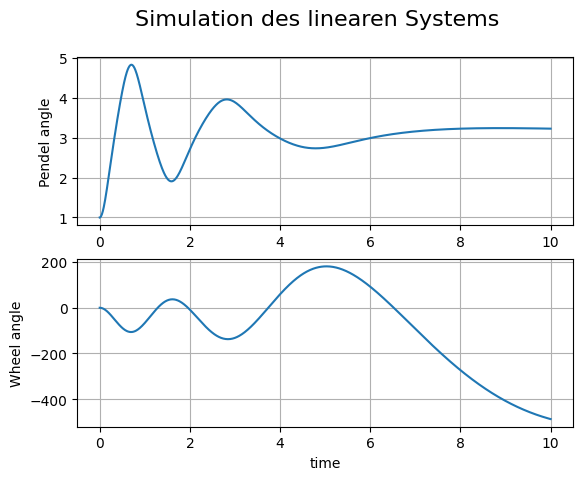

In [2]:
def reaction_wheel(config, process_queue=None, return_dict=dict()):
    # nonlinear system parameters
    param = config["system_parameters"]
    K1 = param["ue"] * param["k"]
    K2 = param["ue"] * param["k"] / (param["Ra"] * param["J"])
    K3 = param["ue"] * param["k"] / (param["Ra"] * param["Ja"])
    K4 = param["m"] * param["g"] * param["l"] / param["J"]
    A = np.array([[0, 1, 0, 0],
                  [0, -K1*K2, 0, K1*K2],
                  [0, 0, 0, 1],
                  [0, K1*K3, 0, -K1*K3]])
    a = np.array([[0],
                  [-K4],
                  [0],
                  [0]])
    b = np.array([[0],
                  [-K2],
                  [0],
                  [K3]])

    # linearization
    A_tilde = A.copy()
    rest = config["control_parameters"]["rest"]
    if rest == "instable":
        x_rest = [np.pi, 0, 0, 0]
        A_tilde[1, 0] = -a.item(1)
    elif rest == "stable":
        x_rest = [0, 0, 0, 0]
        A_tilde[1, 0] = a.item(1)
    else:
        raise NotImplementedError

    # pole placement
    poles = config["control_parameters"]["poles"]
    k_acker = place_poles(A_tilde, b, poles).gain_matrix

    # simulation
    def sys_input(t, x):
        return -k_acker @ (x - x_rest)
    def sys_rhs(t, x):
        return A @ x + (a * np.sin(x[0]) + b * sys_input(t, x)).flatten()
    sim_params = config["simulation_parameters"]
    t_span = sim_params["t_span"]
    points = np.linspace(t_span[0], t_span[1], sim_params["n_points"])
    sim_data = solve_ivp(sys_rhs, t_span, sim_params["x0"], t_eval=points)
    
    # send live results, for demonstrative purposes
    if process_queue is not None:
        for i in range(len(sim_data.t)):
            process_queue.put(dict(
                time=sim_data.t[i],
                pendel_angle=sim_data.y[0,i],
                wheel_angle=sim_data.y[2,i],
                sys_input=-k_acker@sim_data.y[:,i],
                progress=i/len(sim_data.t)*100
            ))
            time.sleep(.005)
    
    # return final results
    return_dict.update(dict(time=sim_data.t,
                            pendel_angle=sim_data.y[0,:],
                            wheel_angle=sim_data.y[2,:],
                            sys_input=-(k_acker@sim_data.y).flatten(),
                            control_gani=k_acker,
                           ))
    
configs = jt.load_configs_from_file("reaction_wheel.yml")
return_dict = dict()
reaction_wheel(configs[1], None, return_dict)

# Plot der Simulation des linearen Systems
fig = plt.figure()
plt.suptitle('Simulation des linearen Systems', size=16)
plt.subplot(211)
plt.plot(return_dict["time"], return_dict["pendel_angle"])
plt.grid()
plt.ylabel('Pendel angle')
plt.subplot(212)
plt.plot(return_dict["time"], return_dict["wheel_angle"])
plt.grid()
plt.ylabel('Wheel angle')
plt.xlabel('time')

fig

In [3]:
class ReactionWheel(MplReplayPlot):
    pendel_length = 0.19
    wheel_radius = 0.12
    margin = 0.03
    y_max_plot = pendel_length + wheel_radius + margin
    y_min_plot = -pendel_length - wheel_radius - 0.05
    x_max_plot = y_max_plot
    x_min_plot = -y_max_plot
    shaft_radius = 0.1 * pendel_length
    spoke_width = 0.1 * wheel_radius
    n_spokes = 3

    def __init__(self, jobs):
        jobs_valid = len(jobs) == 1
        super().__init__(jobs, figsize=(4, 4), jobs_valid=jobs_valid)
        
        self.job = jobs[0]

        self.axes = self.fig.add_subplot(111)
        self.axes.set_xlim(self.x_min_plot, self.x_max_plot)
        self.axes.set_ylim(self.y_min_plot, self.y_max_plot)
        self.axes.set_aspect("equal")

        self.base1 = mpl.patches.Rectangle(xy=[-0.085, -0.05], width=0.17, height=0.1, color="lightgrey")
        self.base2 = mpl.patches.Rectangle(xy=[-0.065, -0.05 - 0.28], width=0.13, height=0.28, color="lightgrey")
        self.base3 = mpl.patches.Rectangle(xy=[-0.14, -0.05 - 0.28 - 0.03], width=0.28, height=0.03, color="lightgrey")
        self.axes.add_patch(self.base1)
        self.axes.add_patch(self.base2)
        self.axes.add_patch(self.base3)

        self.pendel_shaft = mpl.patches.Circle(xy=[0, 0], radius=self.shaft_radius, color="darkgrey", zorder=3)
        pendel_trans = mpl.transforms.Affine2D().rotate_deg(-180) + self.axes.transData
        self.pendel = mpl.patches.Rectangle(xy=[-0.05 * self.pendel_length, 0], width=0.1 * self.pendel_length,
                                            height=self.pendel_length, color="#AE7EAE", transform=pendel_trans)

        self.wheel_shaft = mpl.patches.Circle(xy=[0, -self.pendel_length], radius=self.shaft_radius, color="darkgrey",
                                              zorder=3)
        self.wheel = mpl.patches.Wedge(center=[0, -self.pendel_length], theta1=0, theta2=360, r=self.wheel_radius,
                                       color="lightblue", zorder=3, width=self.spoke_width)
        spokes_trans = [mpl.transforms.Affine2D().rotate_deg_around(0, -self.pendel_length,
                                                                    i * 360 / self.n_spokes - 180) + self.axes.transData
                        for i in range(self.n_spokes)]
        self.spokes = [mpl.patches.Rectangle(xy=[-self.spoke_width / 2, -self.pendel_length], width=self.spoke_width,
                                             height=self.wheel_radius * 0.95, transform=s_t, color="lightblue") for s_t in
                       spokes_trans]

        self.axes.add_patch(self.pendel_shaft)
        self.axes.add_patch(self.pendel)
        self.axes.add_patch(self.wheel_shaft)
        self.axes.add_patch(self.wheel)
        [self.axes.add_patch(spoke) for spoke in self.spokes]
        
        self.fig.canvas.flush_events()
    
    def update_plot(self, time=None):
        
        if time is None:
            p_angle = self.job.result["pendel_angle"][-1]
            w_angle = self.job.result["wheel_angle"][-1]

        else:
            p_angle = np.interp(time, self.job.result["time"], self.job.result["pendel_angle"])
            w_angle = np.interp(time, self.job.result["time"], self.job.result["wheel_angle"])

        x = np.array([p_angle, 0, w_angle, 0])

        phiP = np.rad2deg(x[0])
        phiR = np.rad2deg(x[2])
        shaft_pos = np.array([np.sin(x[0]), -np.cos(x[0])]) * self.pendel_length

        pendel_trans = mpl.transforms.Affine2D().rotate_deg(phiP-180) + self.axes.transData
        self.pendel.set_transform(pendel_trans)
        self.wheel_shaft.center = [shaft_pos[0], shaft_pos[1]]
        self.wheel.set_center([shaft_pos[0], shaft_pos[1]])

        spokes_trans = [mpl.transforms.Affine2D().rotate_deg_around(
            shaft_pos[0], shaft_pos[1], i * 360 / self.n_spokes - 180 + phiR) + self.axes.transData
                        for i in range(self.n_spokes)]
        [spoke.set_xy([shaft_pos[0]-self.spoke_width/2, shaft_pos[1]]) for spoke in self.spokes]
        [spoke.set_transform(s_t) for spoke, s_t in zip(self.spokes, spokes_trans)]

        #self.fig.canvas.draw()
        self.fig.canvas.draw_idle()
        self.fig.canvas.flush_events()

#fig = ReactionWheel([jt.Job(jt.Configuration(jt.load_configurations("reaction_wheel.yml"), reaction_wheel))])
#fig.widget

In [4]:
ui = jt.UserInterface()
ui.scheduler.add_function(reaction_wheel)
ui.scheduler.add_configs(jt.load_configs_from_file("reaction_wheel.yml"))
ui.visualizer.add_plot_widget(jt.TimeSeriesReplayPlot)
ui.visualizer.add_plot_widget(ReactionWheel)
ui.set_auto_add_to_visu()
ui

UserInterface(children=(SchedulerInterface(children=(GridBox(children=(FileUpload(value=(), accept='.yml,.yaml…

In [5]:
slider_mpl = ui.visualizer.plot_list.item_list[0].replay_panel.time_slider
slider_bq = ui.visualizer.plot_list.item_list[1].replay_panel.time_slider
iw.link((slider_mpl, "value"), (slider_bq, "value"))

IndexError: list index out of range